In [1]:
import os
os.chdir('/nfs/homedirs/ayle/guided-research/SNIP-it/bayesian')
import sys
sys.path.append('/nfs/homedirs/ayle/guided-research/SNIP-it')

from main_bayesian import run

In [ ]:
run(dataset='CIFAR10', net_type='conv6', prune_criterion='SNR', pruning_limit=0.5, lower_limit=0.2, checkpoint='/nfs/homedirs/ayle/guided-research/SNIP-it/bayesian/checkpoints/CIFAR10/bayesian/model_conv6_bbb_relu_copy.pt')

In [2]:
import argparse
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import torchvision
from torch.nn import functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pickle

import data
from main_bayesian import getModel
import config_bayesian as cfg

from main_bayesian import validate_model
import metrics
from uncertainty_estimation import *

In [3]:
# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
in_data = init_dataset('CIFAR10')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
ood_data = init_dataset('SVHN')

Using downloaded and verified file: ../gitignored/data/train_32x32.mat
Using downloaded and verified file: ../gitignored/data/test_32x32.mat


In [6]:
net_type = 'conv6'

In [ ]:
# LOAD STRUCTURED PRUNED MODEL
if net_type == 'customconv6':
    import pickle
    with open('./checkpoints/CIFAR10/bayesian/model_conv6_bbb_relu_StructuredSNR_0.5.pt', 'rb') as f:
         net = pickle.load(f)

In [ ]:
with open('/nfs/homedirs/ayle/model_conv6_0.5.pickle', 'rb') as f:
     pre_pruned_model = pickle.load(f)

In [ ]:
pre_pruned_model

In [ ]:
net = getModel(net_type, 3, 10, priors=None, layer_type='bbb', activation_type='relu', pre_pruned_model=None)

In [ ]:
net.load_state_dict(torch.load('./checkpoints/CIFAR10/bayesian/model_conv6_bbb_relu_SNR_0.5_after.pt'))
net.eval()
net.to(device)

In [ ]:
with open('/nfs/homedirs/ayle/mask.pickle', 'rb') as f:
    mask = pickle.load(f)

mask_keys = list(mask.keys())

count = 0
for name, module in net.named_modules():
    if name.startswith('conv') or name.startswith('fc'):
        module.mask = mask[mask_keys[count]]
        count += 1

In [7]:
import pickle
with open('./checkpoints/CIFAR10/bayesian/model_conv6_bbb_relu_StructuredSNR_0.5_during.pt', 'rb') as f:
     net = pickle.load(f)

In [ ]:
sparsity = 0.7
all_scores = []
for name, module in net.named_modules():
    if name.startswith('conv') or name.startswith('fc'):
        scores = torch.abs(module.W_mu) / torch.log1p(torch.exp(module.W_rho)) # / module.weight.sigma
#         scores = - torch.log1p(torch.exp(module.W_rho)) 
        all_scores.append(scores.flatten())
all_scores = torch.cat([x for x in all_scores])
threshold, _ = torch.topk(all_scores, int(len(all_scores)*(1-sparsity)), sorted=True)
acceptable_score = threshold[-1]

In [ ]:
for name, module in net.named_modules():
    if name.startswith('conv') or name.startswith('fc'):
        mask = (torch.abs(module.W_mu) / torch.log1p(torch.exp(module.W_rho))) > acceptable_score
#         mask = - torch.log1p(torch.exp(module.W_rho))  > acceptable_score
#         mask = (- module.weight.sigma) > acceptable_score
        module.mask = mask
        
        print(mask.sum().float() / torch.numel(mask))

In [8]:
valid_size = 0.2
batch_size = 256
num_workers = 4

trainset, testset, inputs, outputs = data.getDataset('CIFAR10')
train_loader, valid_loader, test_loader = data.getDataloader(
trainset, testset, valid_size, batch_size, num_workers)

ood_trainset, ood_testset, ood_inputs, ood_outputs = data.getDataset('SVHN')
ood_train_loader, ood_valid_loader, ood_test_loader = data.getDataloader(
ood_trainset, ood_testset, valid_size, batch_size, num_workers)

criterion = metrics.ELBO(len(trainset)).to(device)
beta_type = 0.1
epoch = 1
n_epochs = 1

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ../gitignored/data/train_32x32.mat
Using downloaded and verified file: ../gitignored/data/test_32x32.mat


In [9]:
n_ens = 5

In [10]:
valid_loss, valid_acc, max_probs = validate_model(net, criterion, valid_loader, num_ens=n_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)

0.031717088222503666


In [11]:
valid_acc

0.87109375

In [12]:
ood_valid_loss, _, ood_max_probs = validate_model(net, criterion, ood_valid_loader, num_ens=n_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)

0.03181596131160341


In [13]:
from sklearn import metrics as sk_metrics
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt


def calculate_auroc(correct, predictions):
    fpr, tpr, thresholds = sk_metrics.roc_curve(correct, predictions)
    auroc = sk_metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr)
    return auroc


def calculate_aupr(correct, predictions):
    aupr = sk_metrics.average_precision_score(correct, predictions)
    return aupr

0.8818860623848201
0.8850588808019657


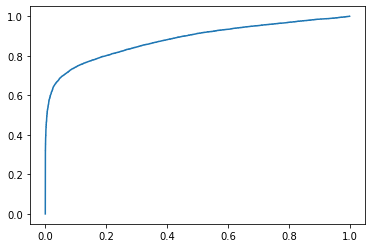

In [14]:
corrects = np.concatenate((np.ones_like(max_probs), np.zeros_like(ood_max_probs)))
print(calculate_auroc(corrects, np.concatenate((max_probs, ood_max_probs))))
print(calculate_aupr(corrects, np.concatenate((max_probs, ood_max_probs))))

In [ ]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms

class DS(Dataset):

    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.mean = [0.485, 0.456, 0.406]  # avg 0.449
        self.std = [0.229, 0.224, 0.225]  # avg 0.226
        self.transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=self.mean, std=self.std)
            ]
        )

    def __getitem__(self, item):
        image = self.images[item] / 255
        image = self.transforms(image.transpose((1, 2, 0)))
        return image.to(torch.float32), torch.tensor(self.labels[item], dtype=torch.long)

    def __len__(self):
        return len(self.images)
    
    
ds_path = '/nfs/homedirs/ayle/guided-research/SNIP-it/gitignored/data/cifar10_corrupted'
for ds_dataset_name in os.listdir(ds_path):
    if ds_dataset_name.startswith('impulse_noise_5') or ds_dataset_name.startswith('elastic_5') or ds_dataset_name.startswith('brightness_5'):
        npz_dataset = np.load(os.path.join(ds_path, ds_dataset_name))

        ds_dataset = DS(npz_dataset["images"], npz_dataset["labels"])
        ds_loader = torch.utils.data.DataLoader(
            ds_dataset,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=4
        )

        ood_valid_loss, ood_acc, ood_max_probs = validate_model(net, criterion, ds_loader, num_ens=n_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)

        print(ds_dataset_name)
        print(ood_acc)
        corrects = np.concatenate((np.ones_like(max_probs), np.zeros_like(ood_max_probs)))
        print(calculate_auroc(corrects, np.concatenate((max_probs, ood_max_probs))))
        print(calculate_aupr(corrects, np.concatenate((max_probs, ood_max_probs))))